# # Multi-Strategy Crypto Backtester
# This notebook implements:
# - Multiple trading strategies (MA, Breakout, BetaRegression, CLV, Fourier)
# - A MultiStrategyEngine to ensemble signals
# - A Backtester that converts ensemble signals into portfolio weights & equity curve


In [1]:
# %%
# 1. Imports & Global Settings

import os
import re
import glob
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import warnings
import quantstats as qs

from sklearn.linear_model import LinearRegression
from skopt import gp_minimize
from skopt.space import Real
from numpy.fft import fft, fftfreq
from scipy.stats import kstest, normaltest, shapiro
from scipy.special import comb
from sklearn.model_selection import TimeSeriesSplit
from dataclasses import dataclass
from typing import List, Dict

warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (10, 4)


# ## 2. Strategy Implementations
#
# Implementations:
# - MovingAverageStrategy
# - BetaRegressionStrategy
# - CLV
# - BreakoutStrategy
# - FourierTransform


In [2]:
# %%
# ---- Moving Average Ensemble Strategy ----

short_period = 6
long_period = 12
ma_method = 'SMA'

class MovingAverageStrategy:
    def __init__(self, short=short_period, long=long_period, method=ma_method):
        self.short = short
        self.long = long
        self.method = method

    def signal(self, index: pd.DatetimeIndex, series: pd.Series) -> pd.DataFrame:
        x = series.values.astype(float)
        methods = ['EMA', 'SMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA']
        vals = []

        for m in methods:
            if m == 'EMA':
                a = talib.EMA(x, timeperiod=self.short)
                b = talib.EMA(x, timeperiod=self.long)
            elif m == 'SMA':
                a = talib.SMA(x, timeperiod=self.short)
                b = talib.SMA(x, timeperiod=self.long)
            elif m == 'WMA':
                a = talib.WMA(x, timeperiod=self.short)
                b = talib.WMA(x, timeperiod=self.long)
            elif m == 'DEMA':
                a = talib.DEMA(x, timeperiod=self.short)
                b = talib.DEMA(x, timeperiod=self.long)
            elif m == 'TEMA':
                a = talib.TEMA(x, timeperiod=self.short)
                b = talib.TEMA(x, timeperiod=self.long)
            elif m == 'TRIMA':
                a = talib.TRIMA(x, timeperiod=self.short)
                b = talib.TRIMA(x, timeperiod=self.long)
            elif m == 'KAMA':
                a = talib.KAMA(x, timeperiod=self.short)
                b = talib.KAMA(x, timeperiod=self.long)
            else:
                continue

            sig = (a - b) > 0
            vals.append(sig.astype(int))

        if not vals:
            return pd.DataFrame({'value': np.zeros(len(index))}, index=index)

        avg = np.nanmean(np.column_stack(vals), axis=1)
        return pd.DataFrame({'value': avg}, index=index)


In [3]:
# %%
# ---- Beta Regression Strategy ----

class BetaRegressionStrategy:
    def __init__(self, beta_lookback_period=12, zscore_lookback_period=72, signal_threshold=0.75):
        self.beta_lookback_period = beta_lookback_period
        self.zscore_lookback_period = zscore_lookback_period
        self.signal_threshold = signal_threshold

    def signal(self, index: pd.DatetimeIndex,
               low_series: pd.Series,
               high_series: pd.Series) -> pd.DataFrame:
        x = pd.Series(low_series.values.astype(float), index=index)
        y = pd.Series(high_series.values.astype(float), index=index)
        w = self.beta_lookback_period

        mx = x.rolling(w).mean()
        my = y.rolling(w).mean()
        mxx = (x * x).rolling(w).mean()
        myy = (y * y).rolling(w).mean()
        mxy = (x * y).rolling(w).mean()

        varx = mxx - mx * mx
        vary = myy - my * my
        cov = mxy - mx * my

        beta_s = cov / varx
        corr = cov / (np.sqrt(varx) * np.sqrt(vary))
        r2_s = corr * corr

        mean_beta = beta_s.rolling(self.zscore_lookback_period).mean()
        std_beta = beta_s.rolling(self.zscore_lookback_period).std()
        z = (beta_s - mean_beta) / std_beta

        strength = z * r2_s
        weight = strength.where(beta_s > self.signal_threshold, 0.0).fillna(0.0)

        return pd.DataFrame({'value': weight.astype(float)}, index=index)


In [4]:
# %%
# ---- CLV Strategy ----

class CLV:
    def __init__(self, threshold=-1):
        self.threshold = threshold

    def signal(self, index: pd.DatetimeIndex, clv_series: pd.Series) -> pd.DataFrame:
        y = (clv_series == self.threshold).fillna(0)
        return pd.DataFrame({'value': y.astype(int)}, index=index)


In [5]:
# %%
# ---- Breakout Strategy ----

class BreakoutStrategy:
    def __init__(self, ma_long=50, ma_short=20, breakout_lookback=20, atr_period=14):
        self.ma_long = ma_long
        self.ma_short = ma_short
        self.breakout_lookback = breakout_lookback
        self.atr_period = atr_period

    def signal(self, index: pd.DatetimeIndex,
               low_series: pd.Series,
               high_series: pd.Series) -> pd.DataFrame:
        close = (low_series + high_series) / 2.0

        ma_long = close.rolling(self.ma_long).mean()
        ma_short = close.rolling(self.ma_short).mean()

        high_n = close.rolling(self.breakout_lookback).max()
        low_n = close.rolling(self.breakout_lookback).min()

        prev_close = close.shift()
        tr1 = high_n - low_n
        tr2 = (high_n - prev_close).abs()
        tr3 = (low_n - prev_close).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(self.atr_period).mean()

        breakout_up = (close > ma_long) & (close > high_n.shift(1))
        breakout_down = (close < ma_short) & (close < low_n.shift(1))

        sig = pd.Series(0.0, index=index)
        sig.loc[breakout_up] = 1.0
        sig.loc[breakout_down] = -1.0

        sig_smooth = sig.rolling(window=self.ma_short, min_periods=1).mean().fillna(0.0)

        return pd.DataFrame({'value': sig_smooth.astype(float)}, index=index)


In [6]:
# %%
# ---- Fourier Transform Strategy ----

class FourierTransform:
    def __init__(self,
                 time_series_datapoints=288,
                 low_energy_threshold=0.5,
                 mid_energy_threshold=0.1,
                 low_slope_threshold=0.0,
                 mid_slope_threshold=0.0):
        self.recents = int(time_series_datapoints)
        self.low_energy_threshold = float(low_energy_threshold)
        self.mid_energy_threshold = float(mid_energy_threshold)
        self.low_slope_threshold = float(low_slope_threshold)
        self.mid_slope_threshold = float(mid_slope_threshold)
        self.low_grid = np.arange(0.01, 0.09, 0.01)
        self.high_grid = np.arange(0.06, 0.21, 0.01)

    def discrete_fourier_transform(self, s: pd.Series, recents: int) -> pd.DataFrame:
        x = s.dropna().sort_index().tail(recents)
        n = len(x)
        if n == 0:
            return pd.DataFrame({"frequency": [], "magnitude": []})
        dt = 1.0
        y = x.values
        yf = fft(y)
        xf = fftfreq(n, d=dt)
        pos = xf > 0
        xf = xf[pos]
        mag = np.abs(yf)[pos]
        return pd.DataFrame({"frequency": xf, "magnitude": mag})

    def reconstruct_time_series(self, s: pd.Series,
                                low_filter: float,
                                high_filter: float,
                                band: str) -> pd.Series:
        x = s.dropna().sort_index()
        y = x.values
        n = len(x)
        if n == 0:
            return pd.Series([], dtype=float)

        F = np.fft.rfft(y, n=n)
        f = np.fft.rfftfreq(n, d=1.0)

        if band == "low":
            mask = f < low_filter
        elif band == "middle":
            mask = (f >= low_filter) & (f <= high_filter)
        else:
            mask = f > high_filter

        y_band = np.fft.irfft(F * mask, n=n)
        return pd.Series(y_band, index=x.index)

    def frequency_filter(self, spec_df: pd.DataFrame,
                         low_filter: float,
                         high_filter: float):
        d = spec_df.dropna()
        low = d[d["frequency"] < low_filter]
        mid = d[(d["frequency"] >= low_filter) & (d["frequency"] <= high_filter)]
        high = d[d["frequency"] > high_filter]
        return low, mid, high

    def normality_test(self, arr):
        x = np.asarray(arr)
        if len(x) < 8 or np.allclose(x.std(ddof=1), 0):
            return 1.0, 1.0, 1.0
        z = (x - x.mean()) / x.std(ddof=1)
        return (
            kstest(z, "norm").pvalue,
            normaltest(x).pvalue,
            shapiro(x).pvalue
        )

    def seasonality_test(self, spec_df: pd.DataFrame) -> float:
        d = spec_df.dropna()
        if len(d) == 0:
            return 1.0
        p = (d["magnitude"].values ** 2)
        mx = float(p.max())
        tot = float(p.sum())
        g = mx / tot if tot > 0 else 0.0
        m = len(p)
        if g <= 0 or m <= 1:
            return 1.0
        kmax = int(np.floor(1.0 / g)) if g > 0 else 0
        pv = 0.0
        for k in range(1, kmax + 1):
            pv += ((-1)**(k-1)) * comb(m, k, exact=False) * (1 - k*g)**(m-1)
        return float(pv)

    def compute_energy(self, spec_df: pd.DataFrame,
                       low_filter: float,
                       high_filter: float):
        d = spec_df.dropna()
        if len(d) == 0:
            return 0.0, 0.0, 0.0
        f = d["frequency"].values
        m2 = (d["magnitude"].values ** 2)
        low = float(m2[f < low_filter].sum())
        mid = float(m2[(f >= low_filter) & (f < high_filter)].sum())
        high = float(m2[f >= high_filter].sum())
        tot = low + mid + high
        if tot > 0:
            low /= tot
            mid /= tot
            high /= tot
        return low, mid, high

    def compute_slope(self, s: pd.Series, inst_regression: int) -> float:
        y = s.dropna().tail(inst_regression).values
        if len(y) < 2:
            return 0.0
        X = np.arange(len(y)).reshape(-1, 1)
        return float(LinearRegression().fit(X, y).coef_[0])

    def choose_filter_bound(self, s: pd.Series,
                            spec_df: pd.DataFrame,
                            low_grid,
                            high_grid):
        for low in low_grid:
            for high in high_grid:
                if high <= low:
                    continue
                hf = self.reconstruct_time_series(s, low, high, "high")
                r = pd.Series(hf).diff().dropna()
                p1, p2, p3 = self.normality_test(r)

                _, mid_spec, _ = self.frequency_filter(spec_df, low, high)
                pv_season = self.seasonality_test(mid_spec)

                if (p1 < 0.05) and (p2 < 0.05) and (p3 < 0.05) and (pv_season < 0.05):
                    return float(low), float(high)
        return None

    def signal(self, index: pd.DatetimeIndex,
               vwap_series: pd.Series) -> pd.DataFrame:
        s = vwap_series.dropna().sort_index()
        s = np.log(s[s > 0])

        if len(s) < self.recents:
            return pd.DataFrame({'value': pd.Series(0.0, index=index)})

        spec_last = self.discrete_fourier_transform(s, self.recents)
        chosen = self.choose_filter_bound(s, spec_last, self.low_grid, self.high_grid)
        if chosen is None:
            return pd.DataFrame({'value': pd.Series(0.0, index=index)})

        low_f, high_f = chosen
        weights = pd.Series(0.0, index=s.index, dtype=float)

        step = self.recents
        inst_reg = max(8, self.recents // 6)

        for t in range(self.recents, len(s) + 1, step):
            sw = s.iloc[:t].tail(self.recents)
            spec_t = self.discrete_fourier_transform(sw, self.recents)
            el, em, eh = self.compute_energy(spec_t, low_f, high_f)

            low_ts = self.reconstruct_time_series(sw, low_f, high_f, "low")
            mid_ts = self.reconstruct_time_series(sw, low_f, high_f, "middle")

            sl = self.compute_slope(low_ts, inst_reg)
            sm = self.compute_slope(mid_ts, inst_reg)

            ok = (
                (el >= self.low_energy_threshold) and
                (em >= self.mid_energy_threshold) and
                (sl >= self.low_slope_threshold) and
                (sm >= self.mid_slope_threshold)
            )

            if ok:
                w = max(
                    0.0,
                    1.0 - (eh / el if el > 0 else 1.0) - (eh / em if em > 0 else 1.0)
                )
            else:
                w = 0.0

            weights.iloc[t - 1] = float(max(w, 0.0))

        weights = weights.replace(0, np.nan).ffill().fillna(0.0)

        full = pd.Series(0.0, index=index, dtype=float)
        full.loc[weights.index] = weights.values
        full = full.ffill().fillna(0.0)

        return pd.DataFrame({'value': full}, index=index)



# ## 3. Multi-Strategy Engine
#
# Combines individual strategy signals into a single ensemble signal per asset.


In [7]:
# %%
@dataclass
class StrategyConfig:
    strategy: object
    series_names: List[str]
    weight: float = 1.0
    long_only: bool = True


class MultiStrategyEngine:
    def __init__(self, configs: List[StrategyConfig], combine: str = 'weighted_sum'):
        if not configs:
            raise ValueError("MultiStrategyEngine requires at least one StrategyConfig.")
        self.configs = configs
        self.combine = combine

    def _signal_one_strategy_one_symbol(
        self,
        cfg: StrategyConfig,
        index: pd.DatetimeIndex,
        series_map: Dict[str, pd.Series]
    ) -> pd.Series:
        args = [series_map[name] for name in cfg.series_names]
        df = cfg.strategy.signal(index, *args)
        s = df['value'].astype(float)
        if cfg.long_only:
            s = s.clip(lower=0.0)
        return s

    def _combine(self, sig_list: List[pd.Series], weights: List[float]) -> pd.Series:
        if not sig_list:
            return pd.Series(0.0)
        base_index = sig_list[0].index
        sig_list = [s.reindex(base_index).fillna(0.0) for s in sig_list]

        if self.combine == 'mean':
            return sum(sig_list) / float(len(sig_list))

        w_sum = float(sum(weights))
        if w_sum == 0:
            return sum(sig_list)

        out = pd.Series(0.0, index=base_index)
        for s, w in zip(sig_list, weights):
            out += s * (w / w_sum)
        return out

    def signal_matrix(
        self,
        index: pd.DatetimeIndex,
        series_mats: Dict[str, pd.DataFrame]
    ) -> pd.DataFrame:
        first_cfg = self.configs[0]
        base_mat = series_mats[first_cfg.series_names[0]]
        symbols = base_mat.columns

        out = {}
        for sym in symbols:
            sigs = []
            wts = []
            for cfg in self.configs:
                series_map = {name: series_mats[name][sym] for name in cfg.series_names}
                s = self._signal_one_strategy_one_symbol(cfg, index, series_map)
                sigs.append(s)
                wts.append(cfg.weight)
            combined = self._combine(sigs, wts)
            out[sym] = combined

        sig_df = pd.DataFrame(out, index=index).fillna(0.0)
        return sig_df



# ## 4. Backtester
#
# - Loads OHLCV data
# - Uses MultiStrategyEngine to get raw signals
# - Maps signals → target weights → positions
# - Computes equity curve, risk metrics, and benchmark comparison


In [8]:
# %%
class Backtester:
    def __init__(self,
                 data_dir: str,
                 strategies_config: List[StrategyConfig],
                 initial_cash: float = 100000.0,
                 commissions: float = 0.001,
                 rebalance: str = 'D',
                 lambda_value: float = 0.9,
                 change_threshold: float = 0.05,
                 start: str = '2024-09-01 00:00:00',
                 end: str = '2025-08-31 23:55:00'):

        self.data_dir = data_dir
        self.initial_cash = float(initial_cash)
        self.commissions = float(commissions)
        self.rebalance = rebalance
        self.lambda_value = float(lambda_value)
        self.change_threshold = float(change_threshold)
        self.start_time = start
        self.end_time = end

        # Load data
        self.data = self.load_data()
        self.open = self.build_matrix('open')
        self.high = self.build_matrix('high')
        self.low = self.build_matrix('low')
        self.close = self.build_matrix('close')
        self.volume = self.build_matrix('volume')
        self.vwap = self.build_matrix('vwap')
        self.clv = self.build_matrix('clv')

        # Multi-strategy ensemble
        if not strategies_config:
            strategies_config = [
                StrategyConfig(BreakoutStrategy(), ['low', 'high'], weight=1.0, long_only=False)
            ]
        self.multi_engine = MultiStrategyEngine(strategies_config)

        # Build signals & weights
        self.weights_raw = self.build_weights()
        self.exp_weights = self.exponential_weights(self.weights_raw, lam=self.lambda_value)
        self.weights = self.positions(self.exp_weights, trade_threshold=self.change_threshold)

        # Returns & equity
        self.returns = self.close.pct_change().fillna(0.0)
        self.equity_curve = self.compute_equity_curve()
        self.metrics = self.compute_risk_metrics()

    # ----- Data -----

    def load_data(self) -> Dict[str, pd.DataFrame]:
        out = {}
        for fp in sorted(glob.glob(f"{self.data_dir}/*.csv")):
            df = pd.read_csv(fp, parse_dates=['timestamp'], index_col='timestamp').sort_index()
            df = df.loc[self.start_time:self.end_time]
            base = os.path.basename(fp).split('_')[0]
            base = re.sub(r'USDT$', '', base)
            out[base] = df[['open', 'high', 'low', 'close', 'volume', 'vwap', 'clv']]
        return out

    def build_matrix(self, col: str) -> pd.DataFrame:
        cols = []
        for sym, df in self.data.items():
            if col in df.columns:
                cols.append(df[col].rename(sym))
        if not cols:
            raise ValueError(f"No column '{col}' found in data.")
        return pd.concat(cols, axis=1).sort_index()

    # ----- Signals / Weights -----

    def build_weights(self) -> pd.DataFrame:
        series_mats = {
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'vwap': self.vwap,
            'clv': self.clv
        }

        raw = self.multi_engine.signal_matrix(self.close.index, series_mats)

        sig_df = (
            raw
            .resample(self.rebalance).last()
            .shift(1)
            .fillna(0.0)
        )

        return sig_df

    def exponential_weights(self, weights_df: pd.DataFrame, lam: float = None) -> pd.DataFrame:
        if lam is None:
            lam = self.lambda_value

        ew = pd.DataFrame(index=weights_df.index, columns=weights_df.columns, dtype=float)

        first = weights_df.iloc[0].clip(lower=0.0)
        s = float(first.sum())
        ew.iloc[0] = 0.0 if s == 0 else first / s

        for i in range(1, len(weights_df)):
            w = weights_df.iloc[i].clip(lower=0.0)
            prev = ew.iloc[i - 1]

            blended = lam * w + (1.0 - lam) * prev
            s = float(blended.sum())
            ew.iloc[i] = prev if s == 0 else blended / s

        return ew.fillna(0.0)

    def positions(self,
                  exp_weights_df: pd.DataFrame,
                  trade_threshold: float = None) -> pd.DataFrame:
        if trade_threshold is None:
            trade_threshold = self.change_threshold

        idx = exp_weights_df.index
        pos = pd.DataFrame(index=idx, columns=exp_weights_df.columns, dtype=float)

        pos.iloc[0] = exp_weights_df.iloc[0]

        for i in range(1, len(idx)):
            target = exp_weights_df.iloc[i]
            prev = pos.iloc[i - 1]
            l1_change = (target - prev).abs().sum()

            if l1_change >= trade_threshold:
                pos.iloc[i] = target
            else:
                pos.iloc[i] = prev

        return pos.fillna(0.0)

    # ----- Performance -----

    def compute_equity_curve(self) -> pd.DataFrame:
        idx = self.returns.index
        w = self.weights.reindex(idx).ffill().fillna(0.0)
        w_prev = w.shift(1).fillna(0.0)

        gross = (w_prev * self.returns).sum(axis=1)
        turn = w.diff().abs().sum(axis=1).fillna(0.0)

        net = gross - self.commissions * turn
        equity = (1.0 + net).cumprod() * self.initial_cash

        self.portfolio_value = float(equity.iloc[-1])
        self.net_returns = net
        self.turn = turn

        return equity.to_frame('portfolio_value')

    def compute_risk_metrics(self, r: pd.Series = None) -> pd.Series:
        if r is None:
            r = self.net_returns

        periods_per_year = 365 * 24 * 12

        sharpe = qs.stats.sharpe(r, periods=periods_per_year)
        sortino = qs.stats.sortino(r, periods=periods_per_year)
        calmar = qs.stats.calmar(r, periods=periods_per_year)
        ann_ret = qs.stats.cagr(r, periods=periods_per_year)
        max_dd = qs.stats.max_drawdown(r)
        num_trades = int((self.turn > 1e-8).sum())

        return pd.Series({
            'annualized_return': ann_ret,
            'max_drawdown': max_dd,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'calmar_ratio': calmar,
            'num_trades': num_trades
        })

    # ----- Benchmark -----

    def compute_benchmark(self):
        idx = self.returns.index
        n = len(self.close.columns)
        if n == 0:
            raise ValueError("No assets for benchmark.")

        w = pd.DataFrame(1.0 / n, index=idx, columns=self.close.columns)
        w_prev = w.shift(1).fillna(0.0)

        bench_returns = (w_prev * self.returns).sum(axis=1)
        bench_equity = (1.0 + bench_returns).cumprod() * self.initial_cash
        bench_metrics = self.compute_risk_metrics(bench_returns)

        return bench_equity, bench_returns, bench_metrics

    def strategy_vs_benchmark(self, bench_returns):
        df = pd.concat([self.net_returns, bench_returns], axis=1).dropna()
        if df.empty:
            return np.nan, np.nan, np.nan

        df.columns = ['strategy', 'benchmark']
        X = df['benchmark'].values.reshape(-1, 1)
        y = df['strategy'].values

        lr = LinearRegression(fit_intercept=True)
        lr.fit(X, y)

        beta = float(lr.coef_[0])
        alpha = float(lr.intercept_)
        corr = float(df['strategy'].corr(df['benchmark']))

        print(f"Alpha: {alpha:.8f}")
        print(f"Beta: {beta:.8f}")
        print(f"Correlation: {corr:.8f}")

        return alpha, beta, corr



# ## 5. Configure Strategies & Run Backtest


In [30]:
# %%
strategies = [
    StrategyConfig(MovingAverageStrategy(),  ['vwap'],       weight=0.095, long_only=True),
    StrategyConfig(BreakoutStrategy(),       ['low','high'], weight=0.24, long_only=False),
    StrategyConfig(BetaRegressionStrategy(), ['low','high'], weight=0.34, long_only=True),
    StrategyConfig(CLV(),                    ['clv'],        weight=0.005, long_only=True),
    StrategyConfig(FourierTransform(),       ['vwap'],       weight=0.34, long_only=True),
]

bt = Backtester(
    data_dir='OHLCV_5m_Roostoo',
    strategies_config=strategies,
    initial_cash=100000,
    commissions=0.001,
    rebalance='D',           # try 'W' or '5T' as alternatives
    lambda_value=0.6,
    change_threshold=0.001,   # lower (e.g. 0.01) -> more trades
    start='2024-09-01 00:00:00',
    end='2025-08-31 23:55:00'
)

bt.metrics


annualized_return      0.587172
max_drawdown          -0.669331
sharpe_ratio           0.968991
sortino_ratio          1.347540
calmar_ratio           0.877253
num_trades           364.000000
dtype: float64


# ## 6. Plot Results


Strategy Metrics:
annualized_return      0.586666
max_drawdown          -0.668906
sharpe_ratio           0.968638
sortino_ratio          1.346983
calmar_ratio           0.877053
num_trades           364.000000
dtype: float64

Benchmark Metrics:
annualized_return      0.594838
max_drawdown          -0.663359
sharpe_ratio           0.975975
sortino_ratio          1.357882
calmar_ratio           0.896706
num_trades           364.000000
dtype: float64
Alpha: -0.00000004
Beta: 1.00750535
Correlation: 0.99699180


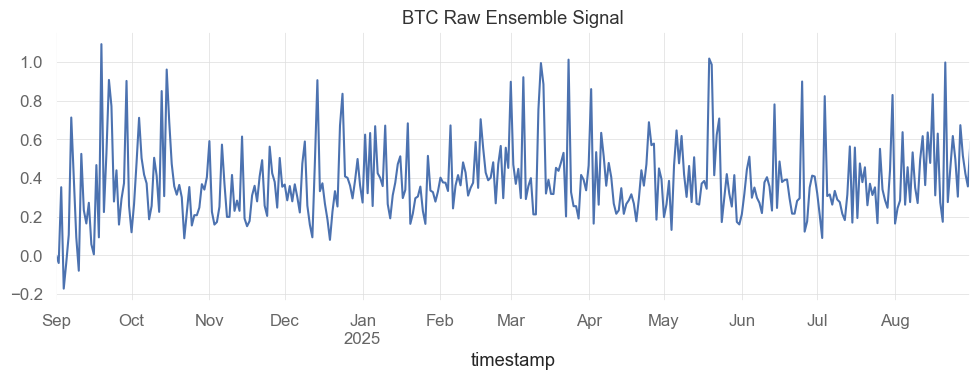

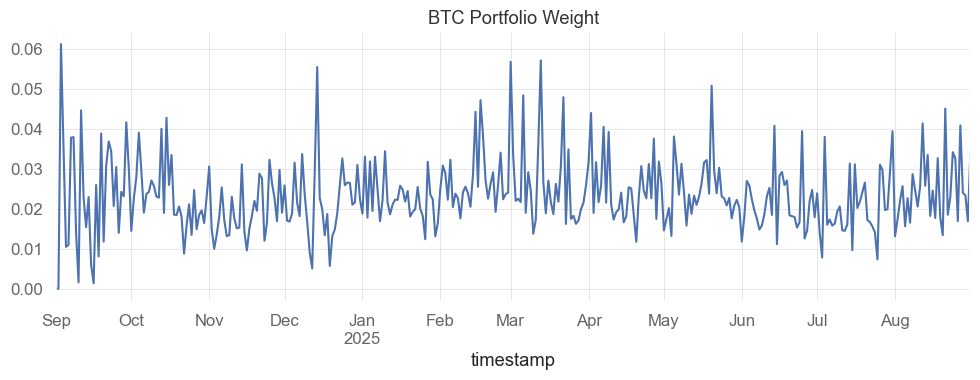

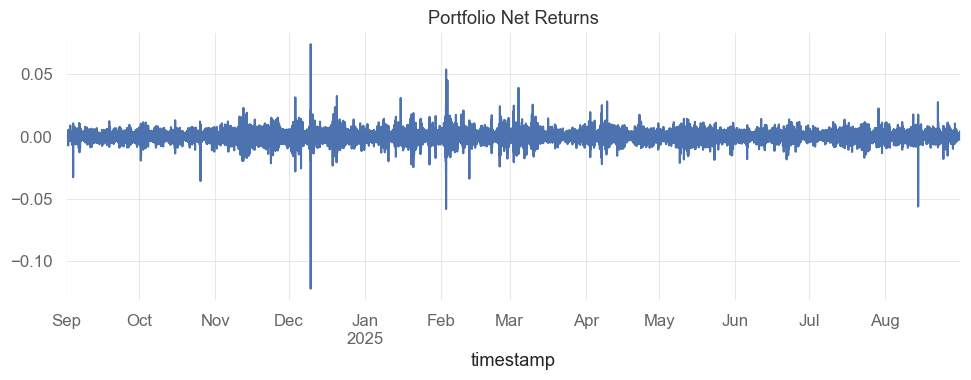

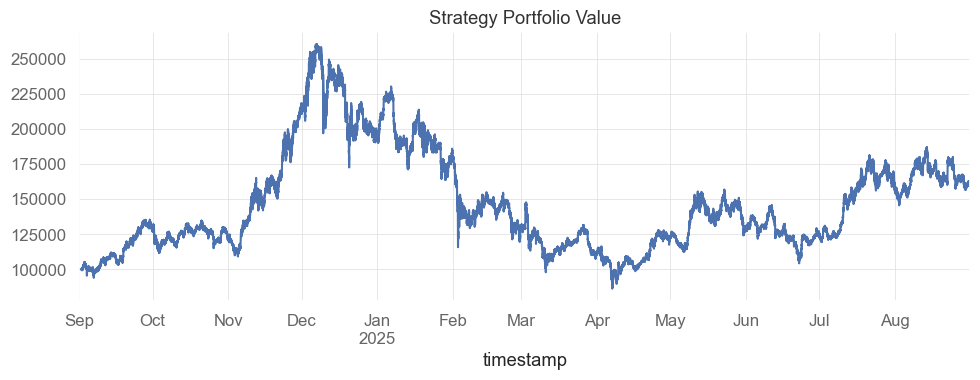

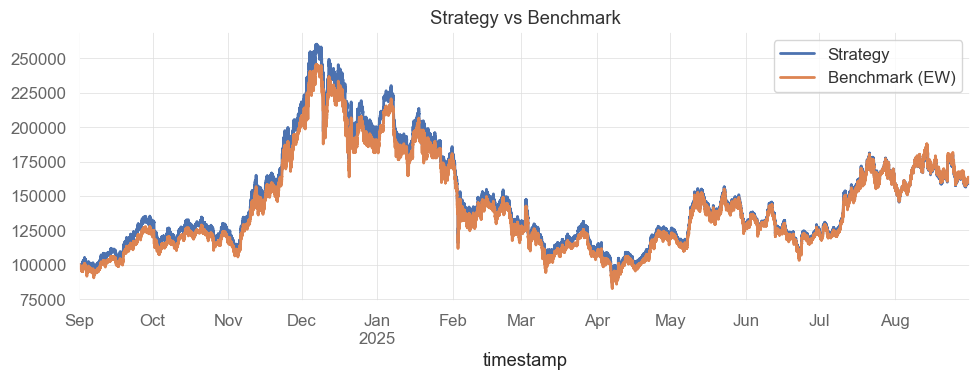

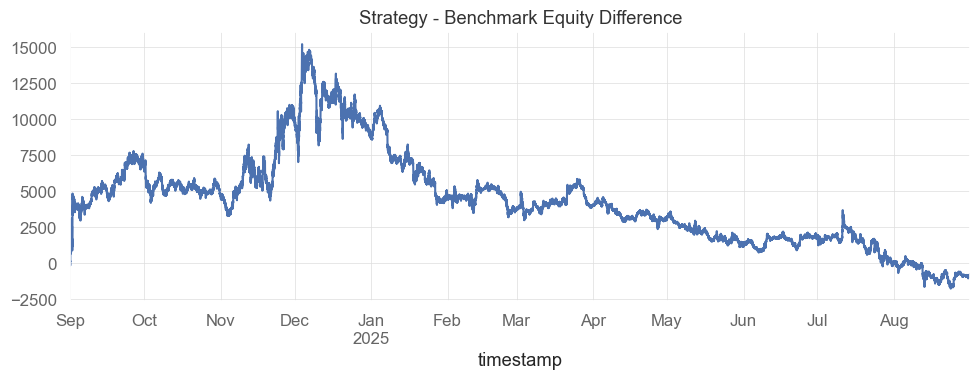

In [26]:
# %%
coin = 'BTC'  # choose any symbol available

# Raw ensemble signal
plt.figure()
bt.weights_raw[coin].plot(title=f'{coin} Raw Ensemble Signal')
plt.tight_layout()

# Final portfolio weight
plt.figure()
bt.weights[coin].plot(title=f'{coin} Portfolio Weight')
plt.tight_layout()

# Net returns
plt.figure()
bt.net_returns.plot(title='Portfolio Net Returns')
plt.tight_layout()

# Equity curve
plt.figure()
bt.equity_curve['portfolio_value'].plot(title='Strategy Portfolio Value')
plt.tight_layout()

# Benchmark comparison
bench_equity, bench_returns, bench_metrics = bt.compute_benchmark()
print("Strategy Metrics:")
print(bt.metrics)
print("\nBenchmark Metrics:")
print(bench_metrics)

alpha, beta, corr = bt.strategy_vs_benchmark(bench_returns)

plt.figure()
bt.equity_curve['portfolio_value'].plot(label='Strategy', linewidth=2)
bench_equity.plot(label='Benchmark (EW)', linewidth=2)
plt.title('Strategy vs Benchmark')
plt.legend()
plt.tight_layout()

# Difference
plt.figure()
(bt.equity_curve['portfolio_value'] - bench_equity).plot(title='Strategy - Benchmark Equity Difference')
plt.tight_layout()

plt.show()


In [32]:
strategies = [
    StrategyConfig(MovingAverageStrategy(),  ['vwap'],      weight=1.0, long_only=True),
    StrategyConfig(BreakoutStrategy(),       ['low','high'], weight=1.0, long_only=False),
    StrategyConfig(BetaRegressionStrategy(), ['low','high'], weight=1.0, long_only=True),
    StrategyConfig(CLV(),                    ['clv'],       weight=0.5, long_only=True),
    StrategyConfig(FourierTransform(),       ['vwap'],      weight=1.0, long_only=True),
]

bt = Backtester(
    data_dir='OHLCV_5m_Roostoo',
    strategies_config=strategies,
    initial_cash=100000,
    commissions=0.001,
    rebalance='D',
    lambda_value=1,
    change_threshold=0,
    start='2024-09-01 00:00:00',
    end='2025-08-31 23:55:00'
)

print("Overall Portfolio Metrics:")
print(bt.metrics)

metric_names = [
    'annualized_return', 'max_drawdown', 'sharpe_ratio', 'sortino_ratio', 'calmar_ratio',
    'num_trades', 'alpha', 'beta', 'correlation'
]

start, end = '2024-09-01 00:00:00', '2025-08-31 23:55:00'
strat_results = {}

def round_metric(val, mult=1.0):
    try: return round(val * mult, 4)
    except: return float('nan')

for strat_cfg in strategies:
    name = type(strat_cfg.strategy).__name__
    bt_ind = Backtester(
        data_dir=bt.data_dir,
        strategies_config=[strat_cfg],
        initial_cash=bt.initial_cash,
        commissions=bt.commissions,
        rebalance=bt.rebalance,
        lambda_value=bt.lambda_value,
        change_threshold=bt.change_threshold,
        start=start,
        end=end
    )
    bench_equity, bench_ret, _ = bt_ind.compute_benchmark()
    alpha, beta, corr = bt_ind.strategy_vs_benchmark(bench_ret)
    m = bt_ind.metrics
    strat_results[name] = {
        'annualized_return': round_metric(m.get('annualized_return')),
        'max_drawdown': round_metric(m.get('max_drawdown')),
        'sharpe_ratio': round_metric(m.get('sharpe_ratio')),
        'sortino_ratio': round_metric(m.get('sortino_ratio')),
        'calmar_ratio': round_metric(m.get('calmar_ratio')),
        'num_trades': round_metric(m.get('num_trades')),
        'alpha': round_metric(alpha, 1e8),
        'beta': round_metric(beta),
        'correlation': round_metric(corr)
    }

# PortfolioStrategy (ensemble)
bench_equity, bench_returns, _ = bt.compute_benchmark()
alpha, beta, corr = bt.strategy_vs_benchmark(bench_returns)
pm = bt.metrics
strat_results['PortfolioStrategy'] = {
    'annualized_return': round_metric(pm.get('annualized_return')),
    'max_drawdown': round_metric(pm.get('max_drawdown')),
    'sharpe_ratio': round_metric(pm.get('sharpe_ratio')),
    'sortino_ratio': round_metric(pm.get('sortino_ratio')),
    'calmar_ratio': round_metric(pm.get('calmar_ratio')),
    'num_trades': round_metric(pm.get('num_trades')),
    'alpha': round_metric(alpha, 1e8),
    'beta': round_metric(beta),
    'correlation': round_metric(corr)
}

# BenchmarkStrategy (equal-weight)
bench_metrics = bt.compute_risk_metrics(bench_returns)
strat_results['BenchmarkStrategy'] = {
    'annualized_return': round_metric(bench_metrics.get('annualized_return')),
    'max_drawdown': round_metric(bench_metrics.get('max_drawdown')),
    'sharpe_ratio': round_metric(bench_metrics.get('sharpe_ratio')),
    'sortino_ratio': round_metric(bench_metrics.get('sortino_ratio')),
    'calmar_ratio': round_metric(bench_metrics.get('calmar_ratio')),
    'num_trades': float('nan'),
    'alpha': float('nan'),
    'beta': float('nan'),
    'correlation': float('nan'),
}

results_df = pd.DataFrame(strat_results).reindex(index=metric_names)
results_df.to_csv('results_df.csv')
print("\nIndividual Strategy Metrics Table:")
print(results_df)

Overall Portfolio Metrics:
annualized_return      0.542850
max_drawdown          -0.669680
sharpe_ratio           0.935799
sortino_ratio          1.301016
calmar_ratio           0.810610
num_trades           364.000000
dtype: float64
Alpha: -0.00000192
Beta: 1.00449327
Correlation: 0.98788380
Alpha: -0.00000655
Beta: 0.97740642
Correlation: 0.87499063
Alpha: -0.00000194
Beta: 1.00648198
Correlation: 0.95310071
Alpha: 0.00000192
Beta: 0.91910638
Correlation: 0.77631169


KeyboardInterrupt: 